# Nama      : Brian Mohamad Safiudin
# NIM       : 2141720133
# Kelas     : TI - 3F

---
# **Praktikum 1 - Pertemuan 10**
---
RNN untuk Analisis Sentimen

In [1]:
# Impor matplotlib dan buat fungsi pembantu untuk memplot grafik
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

---
# **Setup input pipeline**
---
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.
Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
# Awalnya ini mengembalikan dataset (teks, pasangan label)
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [4]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label)
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Although there were some amusing moments, I thought the movie was pretty lame. The longer it ran, the worse it got. Once the action entered Monument Valley, I found myself watching the magnificent outcroppings more than the increasingly silly and unconvincing interaction of the characters.<br /><br />The character of the daughter was particularly incoherent. First she's in on the deal, then discovers the truth and she bails. Then she's back again, then deserts them again. Then she's back again. There's no apparent motivation for any of her decisions. There were interesting characters, some interesting scenes, and many missed possibilities. I would have to say the pictures was much less than the sum of its parts. Apparently the people who liked Repo Man were inclined to like this one. Searchers 2.0 is no match for The Searchers."
 b'My first full Heston movie. The movie that everyone already knows the ending to. A "Sci Fi Thriller". The campy factor. Everything that goes with

---
# **Buat Teks Encoder**
---
Teks mentah yang dimuat oleh tfds perlu diproses sebelum dapat digunakan dalam model. Cara termudah memproses teks untuk pelatihan adalah menggunakan lapisan TextVectorization. Lapisan ini memiliki banyak kemampuan, namun pada tutorial ini menggunakan perilaku default. Buat lapisan tersebut, dan teruskan teks kumpulan data ke metode .adapt lapisan:

In [5]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [6]:
# Metode .adapt mengatur kosakata lapisan. 20 token pertama
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [7]:
# Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[255,  48,  66, ...,   0,   0,   0],
       [ 56,  86, 371, ...,   0,   0,   0],
       [ 15,  34, 288, ...,   0,   0,   0]])

In [8]:
# Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Although there were some amusing moments, I thought the movie was pretty lame. The longer it ran, the worse it got. Once the action entered Monument Valley, I found myself watching the magnificent outcroppings more than the increasingly silly and unconvincing interaction of the characters.<br /><br />The character of the daughter was particularly incoherent. First she's in on the deal, then discovers the truth and she bails. Then she's back again, then deserts them again. Then she's back again. There's no apparent motivation for any of her decisions. There were interesting characters, some interesting scenes, and many missed possibilities. I would have to say the pictures was much less than the sum of its parts. Apparently the people who liked Repo Man were inclined to like this one. Searchers 2.0 is no match for The Searchers."
Round-trip:  although there were some [UNK] moments i thought the movie was pretty lame the [UNK] it [UNK] the worse it got once the action [UNK] 

---
# **Buat Model**
---

In [9]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [10]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [11]:
# evaluasi sebuah kalimat dua kali. Pertama, satu kalimat sehingga tidak ada bantalan
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.0042458]


In [12]:
# evaluasi lagi dalam batch dengan kalimat yang lebih panjang
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 69ms/step
[-0.0042458]


In [13]:
# compile model Keras untuk mengonfigurasi proses pelatihan
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

---
# **Train Model**
---

Epoch 1/10
391/391 [==============================] - 52s 106ms/step - loss: 0.6617 - accuracy: 0.5434 - val_loss: 0.5852 - val_accuracy: 0.6646
Epoch 2/10
391/391 [==============================] - 29s 74ms/step - loss: 0.4305 - accuracy: 0.7906 - val_loss: 0.3727 - val_accuracy: 0.8307
Epoch 3/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3497 - accuracy: 0.8420 - val_loss: 0.3444 - val_accuracy: 0.8516
Epoch 4/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3223 - accuracy: 0.8566 - val_loss: 0.3273 - val_accuracy: 0.8453
Epoch 5/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3115 - accuracy: 0.8650 - val_loss: 0.3203 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 28s 71ms/step - loss: 0.3083 - accuracy: 0.8660 - val_loss: 0.3186 - val_accuracy: 0.8526
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3013 - accuracy: 0.8691 - val_loss: 0.3165 - val_accuracy

(0.0, 0.6800691485404968)

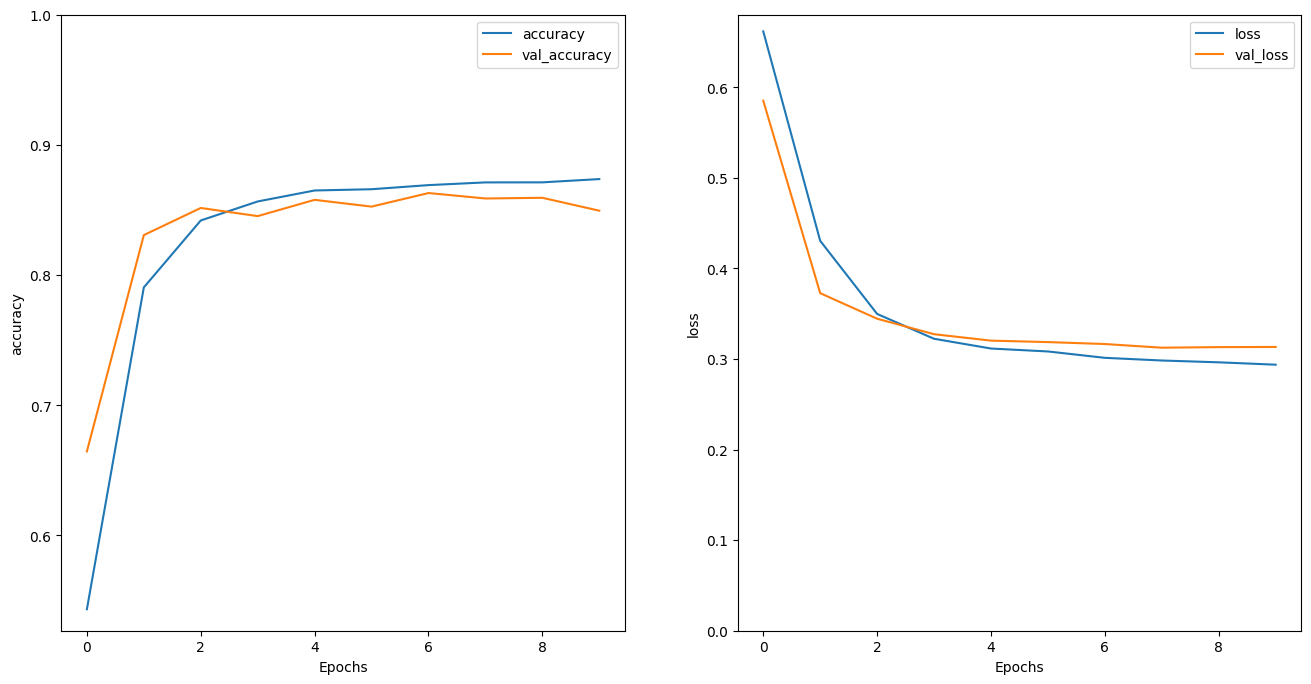

In [14]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [15]:
# Jalankan prediksi pada kalimat baru
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


---
# **Stack two or more LSTM layers**
---
Lapisan berulang Keras memiliki dua mode yang tersedia yang dikontrol oleh argumen konstruktor return_sequences :
- Jika False, ia hanya mengembalikan keluaran terakhir untuk setiap urutan masukan (bentuk tensor 2D (batch_size, output_features)). Ini adalah default yang digunakan pada model sebelumnya. 
- Jika True, Sequence lengkap output berturut-turut untuk setiap langkah waktu dikembalikan (bentuk tensor 3D (ukuran_batch, langkah waktu, fitur_output)).

In [16]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [20]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [21]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 89s 175ms/step - loss: 0.2568 - accuracy: 0.8906 - val_loss: 0.3438 - val_accuracy: 0.8635
Epoch 2/10
391/391 [==============================] - 53s 135ms/step - loss: 0.2532 - accuracy: 0.8938 - val_loss: 0.3391 - val_accuracy: 0.8651
Epoch 3/10
391/391 [==============================] - 54s 138ms/step - loss: 0.2487 - accuracy: 0.8954 - val_loss: 0.3351 - val_accuracy: 0.8531
Epoch 4/10
391/391 [==============================] - 54s 137ms/step - loss: 0.2459 - accuracy: 0.8975 - val_loss: 0.3488 - val_accuracy: 0.8521
Epoch 5/10
391/391 [==============================] - 52s 133ms/step - loss: 0.2446 - accuracy: 0.8970 - val_loss: 0.3503 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 53s 135ms/step - loss: 0.2401 - accuracy: 0.8983 - val_loss: 0.3659 - val_accuracy: 0.8562
Epoch 7/10
391/391 [==============================] - 52s 133ms/step - loss: 0.2396 - accuracy: 0.8997 - val_loss: 0.3645 - val_ac

In [22]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 22s 56ms/step - loss: 0.3851 - accuracy: 0.8507
Test Loss: 0.3850565254688263
Test Accuracy: 0.8507199883460999


In [23]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 5s 5s/step
[[-1.9684271]]


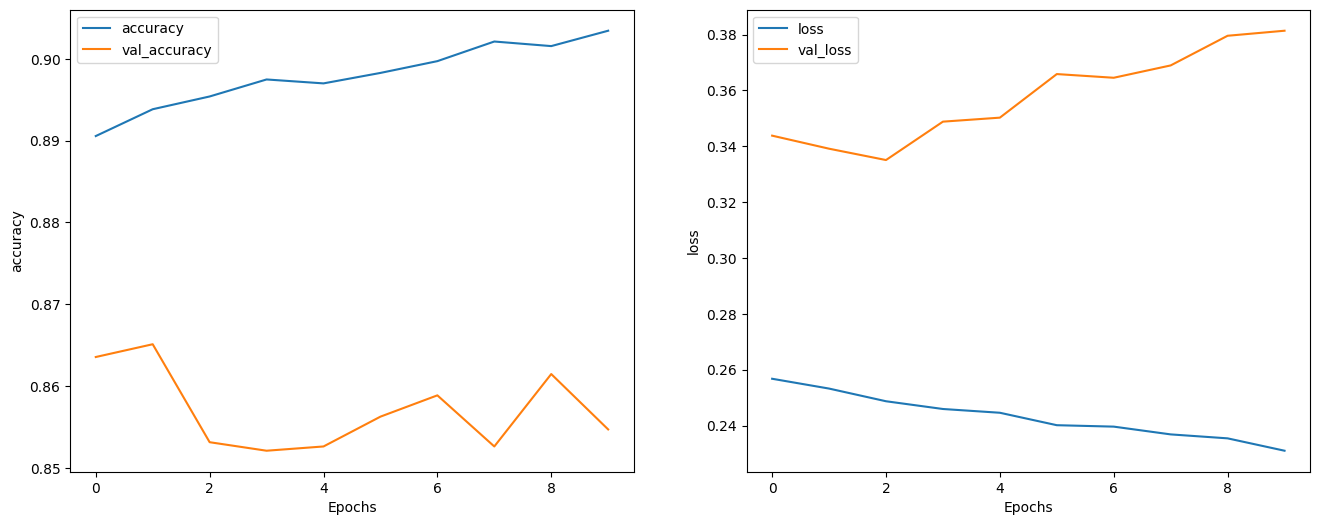

In [24]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')